# **Adverse Drug Reactions**

# **The Classification of ADR-Related Text**

## **About the dataset**

The dataset comprises user-generated reviews sourced from `webmd.com` and `askapatient.com`, focusing on experiences with certain medications. Additionally, the dataset has been enriched by merging it with the `ade corpus v2` (adverse drug event) dataset available on Hugging Face. Each entry in the dataset presents a user's account of their encounters with drugs, detailing personal experiences and observed effects.

###**Variable description**
- **Text**: The textual content or user-generated reviews.
- **Label:** The classification or label indicating the nature of the review - adr(1) or non-adr(0)

## **Data Exploration and Preprocessing**

## **1.1 Importing the required libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from ydata_profiling import ProfileReport
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'ydata_profiling'

In [ ]:
pip install ydata-profiling

In [ ]:
#pip install ydata-profiling
nltk.download('stopwords')
# Load the English stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **1.2 Loading the dataset**

In [ ]:
data=pd.read_csv('adr_data.csv')
data.head(10) # Displaying the first 10 rows of the dataset

In [ ]:
# Exploring the datatypes of the variables present
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24449 entries, 0 to 24448
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    24449 non-null  object
 1   label   24449 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 382.1+ KB


## **1.3 Checking for missing values and duplicates**

In [ ]:
# Checking for missing values
data.isnull().sum()

text              0
label             0
processed_text    0
dtype: int64

In [ ]:
# Checking for duplicated values
duplicates=data.duplicated().sum()
print(f'Number of duplicates found: {duplicates} ')

Number of duplicates found: 0 


In [ ]:
# Dropping the duplicated values
data.drop_duplicates(inplace=True)
shape = data.shape
print(f'Number of rows after dropping duplicates: {shape[0]}')

Number of rows after dropping duplicates: 21829


## **1.4 Preprocessing the text present in the dataset**

In [ ]:
def preprocess_text(text):
    # Converting to lowercase
    text = text.lower()
    # Removing punctuations, digits, and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Removing stop words
    words = [word for word in text.split() if word.lower() not in stop_words]
    processed_text = ' '.join(words)
    return processed_text

# Applying the function to the 'text' column
data['processed_text'] = data['text'].apply(preprocess_text)
data[['text', 'processed_text', 'label']]

,text,processed_text,label
0,"PTSD, was taking Venlafaxine, issue with even...",ptsd taking venlafaxine issue evening depressi...,1
1,I have been on many bipolar medications over t...,many bipolar medications years much luck effec...,1
2,after serveral life changing situations my Dr ...,serveral life changing situations dr put wellb...,1
3,I thought it worked for me but still had depre...,thought worked still depressed thoughts starte...,1
4,Wellbutrin works better than any other anti-de...,wellbutrin works better antidepressent ive tri...,1
...,...,...,...
24444,"At autopsy, the liver was found to be small, s...",autopsy liver found small shrunken scarred his...,0
24445,"Physical exam revealed a patient with aphasia,...",physical exam revealed patient aphasia tremor ...,0
24446,At the time when the leukemia appeared seven o...,time leukemia appeared seven patients complete...,0
24447,The American Society for Regional Anesthesia a...,american society regional anesthesia pain medi...,0


## **1.5 Exploratory Data Analysis**

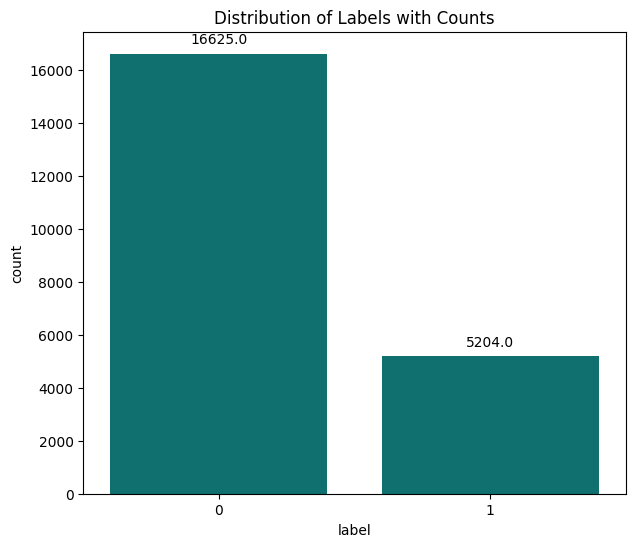

In [ ]:
# Distribution of labels in the dataset
plt.figure(figsize=(7,6))
ax=sns.countplot(x='label',data=data,color='teal')
for p in ax.patches:
   ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.title('Distribution of Labels with Counts')
plt.show()

- Out of the total dataset, 16625 texts have been identified as being related to adverse drug reactions, while 5204 texts are labeled as 0, indicating that they are not associated with side effects.

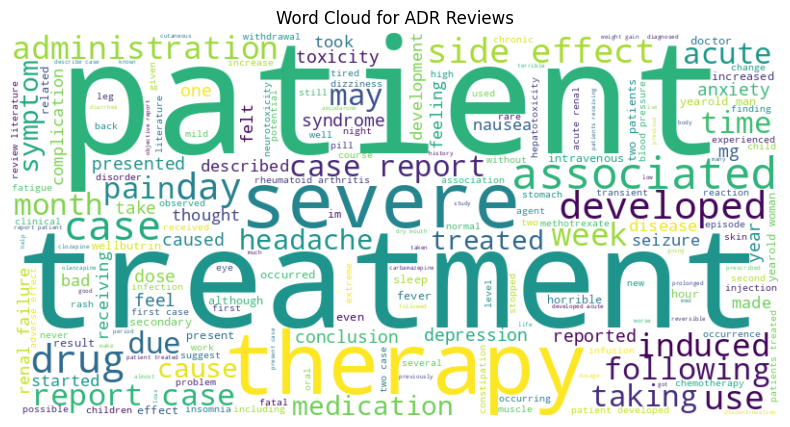

In [ ]:
# Generating word cloud for adr related reviews
adr_reviews = ' '.join(data[data['label'] == 1]['processed_text'])
wordcloud_adr = WordCloud(width=800, height=400, background_color='white').generate(adr_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_adr, interpolation='bilinear')
plt.title('Word Cloud for ADR Reviews')
plt.axis('off')
plt.show()

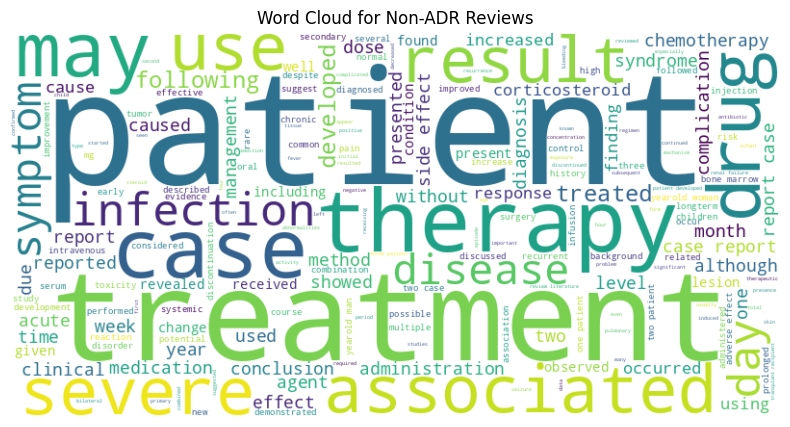

In [ ]:
# Word Cloud for non-adr reviews
non_adr = ' '.join(data[data['label'] == 0]['processed_text'])
wordcloud_non_adr= WordCloud(width=800, height=400, background_color='white').generate(non_adr)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non_adr, interpolation='bilinear')
plt.title('Word Cloud for Non-ADR Reviews')
plt.axis('off')
plt.show()

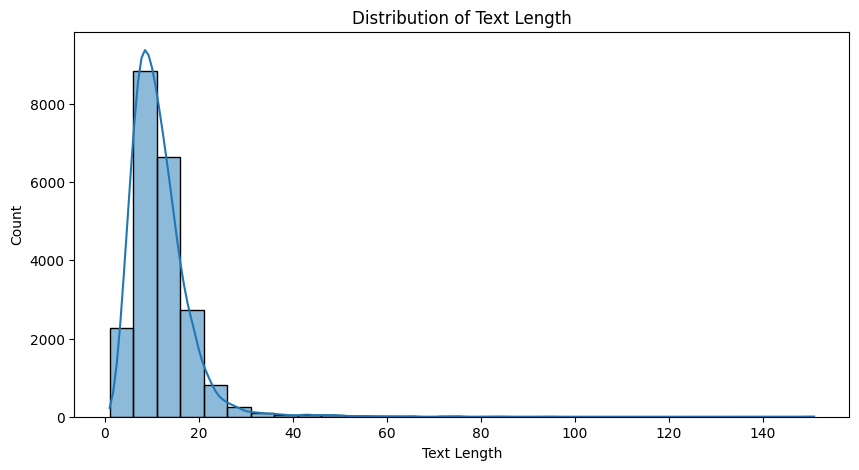

In [ ]:
# Distribution of text length
data['text_length'] = data['processed_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(x='text_length', data=data, bins=30, kde=True)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.show()

**Interpretations**
- The graph shows that most of the texts in the dataset are relatively short, with the most common length being around 10 words. However, there is a long tail of longer texts, with some texts being up to 80 words or more.

In [ ]:
# Boxplot to visualise the text length according to the label
data['text_length'] = data['processed_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='text_length', data=data, palette='Set2')
plt.title('Distribution of Text Lengths by Label')
plt.xlabel('Label')
plt.ylabel('Text Length')
plt.show()

**Interpretations**
- Both classes have a similar distribution of text lengths, with a peak around 20 words and a long tail extending to about 140 words.
- There are some key differences between the two distributions. First, "Label 0" has a higher frequency of shorter texts, with many more data points to the left of the peak than "Label 1". Second, "Label 1" has a slightly higher frequency of longer texts, with a fatter tail to the right of the peak than "Label 0".

## **1.6 Pandas Profiling**

In [ ]:
report=ProfileReport(data)

In [ ]:
report # Displaying the generated report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# **2. Processing the Features**




In [ ]:
# Selecting feature and target variables
X = data['processed_text']
y = data['label']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Applying SMOTE to the training data
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

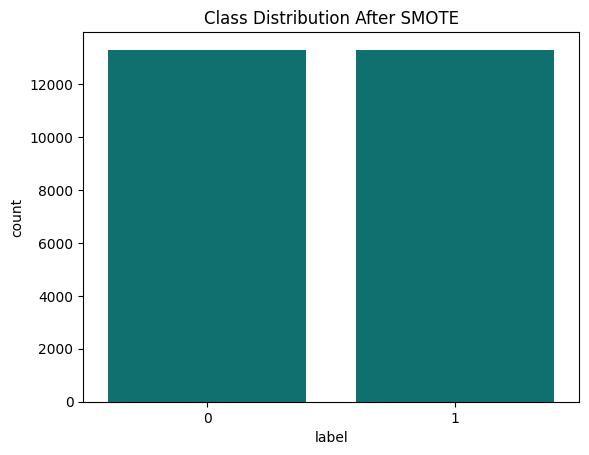

In [ ]:
# Visualizing the count after SMOTE
sns.countplot(x=y_train_resampled,color='teal')
plt.title('Class Distribution After SMOTE')
plt.show()

# **3. Model Building**



In [ ]:
# Building Decision Tree model
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=40, min_samples_leaf=1, min_samples_split=6)
dt_model.fit(X_train_resampled, y_train_resampled)

# Making predictions
dt_predictions = dt_model.predict(X_test_tfidf)

# Evaluating the model
accuracy = accuracy_score(y_test, dt_predictions)
conf_matrix_1 = confusion_matrix(y_test, dt_predictions)
class_report = classification_report(y_test, dt_predictions)
print(f"Decision Tree Accuracy: {accuracy}")
print("\nConfusion Matrix:")
print(conf_matrix_1)
print("\nClassification Report:")
print(class_report)


Decision Tree Accuracy: 0.7872194228126431

Confusion Matrix:
[[3015  313]
 [ 616  422]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      3328
           1       0.57      0.41      0.48      1038

    accuracy                           0.79      4366
   macro avg       0.70      0.66      0.67      4366
weighted avg       0.77      0.79      0.77      4366



In [ ]:
# Building AdaBoost model using Decision Tree as base estimator
adaboost_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=40,min_samples_leaf=1, min_samples_split=6), n_estimators=60, random_state=42)
adaboost_model.fit(X_train_resampled, y_train_resampled)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=40,
                                                         min_samples_split=6),
                   n_estimators=60, random_state=42)

In [ ]:
adaboost_predictions = adaboost_model.predict(X_test_tfidf)

In [ ]:
accuracy = accuracy_score(y_test, adaboost_predictions)
conf_matrix = confusion_matrix(y_test, adaboost_predictions)
class_report = classification_report(y_test, adaboost_predictions)

print(f"\n{model_name} Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


AdaBoost Accuracy: 0.8055428309665598
Confusion Matrix:
[[2967  361]
 [ 488  550]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      3328
           1       0.60      0.53      0.56      1038

    accuracy                           0.81      4366
   macro avg       0.73      0.71      0.72      4366
weighted avg       0.80      0.81      0.80      4366



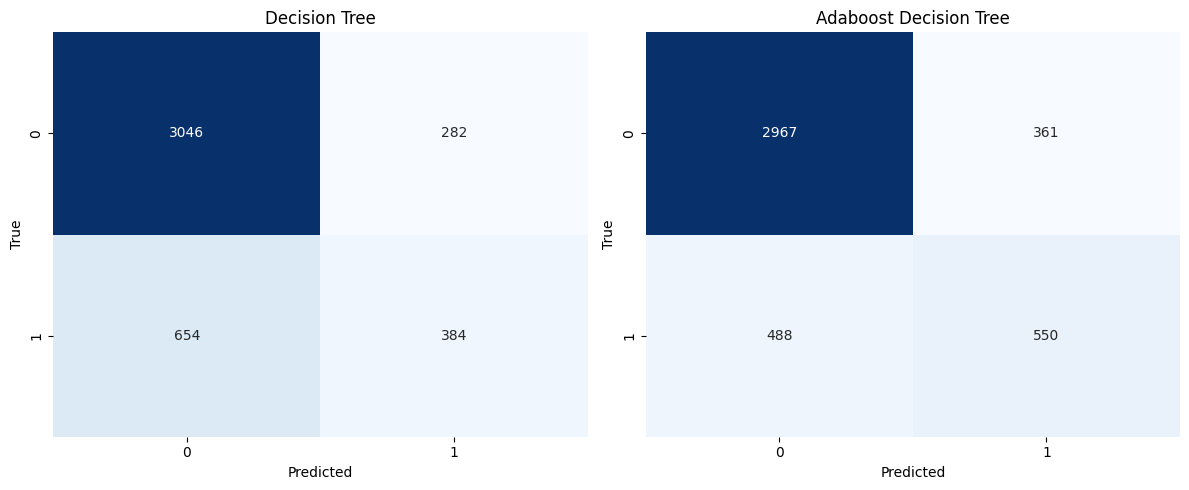

In [ ]:
# Comparison of confusion matrix with and without boosting (with Decision Tree as base model)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(conf_matrix_1, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Decision Tree')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_title('Adaboost Decision Tree')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Building SVM model
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_resampled, y_train_resampled)

# Making predictions
svm_predictions = svm_model.predict(X_test_tfidf)

# Evaluating the model
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_conf_matrix = confusion_matrix(y_test, svm_predictions)
svm_class_report = classification_report(y_test, svm_predictions)
print("SVM Model:")
print(f"Accuracy: {svm_accuracy}")
print("\nConfusion Matrix:")
print(svm_conf_matrix)
print("\nClassification Report:")
print(svm_class_report)

# Building Multinomial Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_resampled, y_train_resampled)

# Making predictions
nb_predictions = nb_model.predict(X_test_tfidf)

# Evaluating the model
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_conf_matrix = confusion_matrix(y_test, nb_predictions)
nb_class_report = classification_report(y_test, nb_predictions)
print("\nMultinomial Naive Bayes Model:")
print(f"Accuracy: {nb_accuracy}")
print("\nConfusion Matrix:")
print(nb_conf_matrix)
print("\nClassification Report:")
print(nb_class_report)

# Building Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=40, min_samples_leaf=1, min_samples_split=6)
rf_model.fit(X_train_resampled, y_train_resampled)

# Making predictions
rf_predictions = rf_model.predict(X_test_tfidf)

# Evaluating the model
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
rf_class_report = classification_report(y_test, rf_predictions)
print("\nRandom Forest Model:")
print(f"Accuracy: {rf_accuracy}")
print("\nConfusion Matrix:")
print(rf_conf_matrix)
print("\nClassification Report:")
print(rf_class_report)


SVM Model:
Accuracy: 0.8607420980302336

Confusion Matrix:
[[2974  354]
 [ 254  784]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      3328
           1       0.69      0.76      0.72      1038

    accuracy                           0.86      4366
   macro avg       0.81      0.82      0.81      4366
weighted avg       0.87      0.86      0.86      4366


Multinomial Naive Bayes Model:
Accuracy: 0.8275309207512598

Confusion Matrix:
[[2799  529]
 [ 224  814]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      3328
           1       0.61      0.78      0.68      1038

    accuracy                           0.83      4366
   macro avg       0.77      0.81      0.78      4366
weighted avg       0.85      0.83      0.83      4366


Random Forest Model:
Accuracy: 0.820888685295465

Confusion Matrix:
[[3108  220]
 [ 562  476]]

Classifi

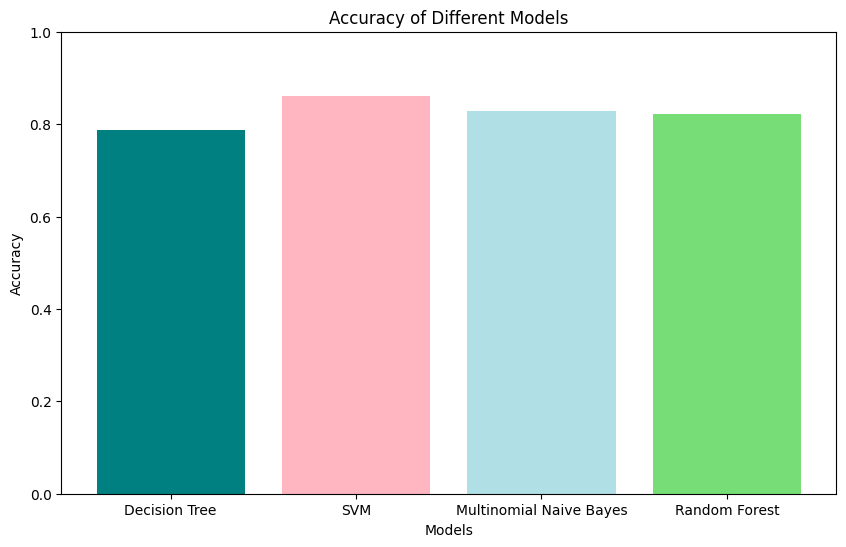

In [ ]:
models = ['Decision Tree', 'SVM', 'Multinomial Naive Bayes', 'Random Forest']
accuracies = [accuracy, svm_accuracy, nb_accuracy, rf_accuracy]
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['teal', 'lightpink', 'powderblue', '#77dd77'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.ylim(0, 1)
plt.show()


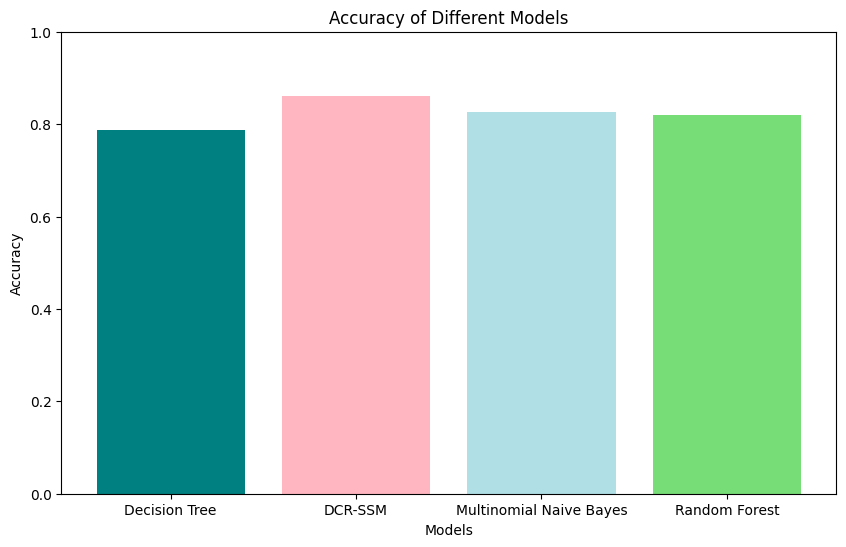

In [ ]:
import matplotlib.pyplot as plt
models = ['Decision Tree', 'DCR-SSM', 'Multinomial Naive Bayes', 'Random Forest']
accuracies = [0.787, 0.86, 0.827, 0.820]
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['teal', 'lightpink', 'powderblue', '#77dd77'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.ylim(0, 1)
plt.show()

#**4.Interpretations**


1. **Accuracy:**
  
  The AdaBoosted Decision Tree model performs slightly better than the standalone Decision Tree model in terms of accuracy (80.6% vs. 78.1%).

2. **Precision, Recall, and F1-Score:**
  
  For both classes (0 and 1), the AdaBoosted Decision Tree model shows improvements in precision, recall, and F1-score compared to the standalone Decision Tree model.
Class 1 (positive class) shows significant improvement in recall for the AdaBoosted model, indicating better ability to identify positive instances.
3. **Confusion Matrix:**
  
  Both models have the same confusion matrix, suggesting that AdaBoosted Decision Tree is enhancing the recall without compromising precision.

**Conclusion**

  AdaBoosting, by combining multiple weak learners (Decision Trees), seems to improve the model's ability to correctly classify positive instances.